In [171]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as U

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
#d = pickle.load(open("forecaster_params.pickle"))
#d["files"] = "tuned_mueller_pulses_selected"
#d["toa_mode"] = "pipeline"
#d = pickle.load(open("fitter_params.pickle"))
#d = pickle.load(open("downhill-runs/dmtesting/fitter_params.pickle"))
d = pickle.load(open("downhill-runs/dailyDM/fitter_params.pickle"))
F = threebody.Fitter(**d)

d

{'dmx_span': 1,
 'efac': 1,
 'fdn_range': (1, 5),
 'files': 'tuned2_aligned_pulses_1400_nosun2',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'linear_dm': False,
 'linear_jumps': True,
 'parfile': '0337_de435.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': 'auto',
 'variable_dm': True,
 'variable_ipm': False}

34475.266936349709717

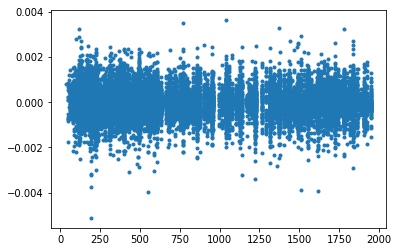

In [296]:
res = F.residuals(F.best_parameters)
plt.plot(F.mjds, res,".")
F.goodness_of_fit()

In [297]:
toa_infos = F.annotated_toas(residuals=F.residuals(), d=F.derivs)

In [298]:
t = toa_infos[0]
print t["flags"]["resid_phase"], t["flags"]["uncert_phase"]
print t["flags"]["resid_phase"]/t["flags"]["uncert_phase"]
print F.residuals()[0], F.uncerts[0]
print 1e-6*t["uncert"]*F.reference_f0

0.00082768779248 0.00080370190105
1.02984426365
0.00082768779248 2.19618664464e-06
0.00080370190105


In [299]:
zs = [np.abs(t["flags"]["resid_phase"]/t["flags"]["uncert_phase"])
      for t in toa_infos]
ix = np.argsort(zs)[::-1]
i = 0
files = {}
z = np.inf
while(z)>10:
    t = toa_infos[ix[i]]
    f = t["file"]
    o = f.split("/")[2]
    if o not in files:
        z = zs[ix[i]]
        files[o] = [z,
                    1e6*t["flags"]["resid_s"], 
                    t["uncert"], 
                    0]
    files[o][3] += 1        
    i += 1
    
os = []
zss = []
rs = []
us = []
ns = []
for k, v in sorted(files.items()):
    os.append(k)
    zss.append(v[0])
    rs.append(v[1])
    us.append(v[2])
    ns.append(v[3])
    
rows = [[k, v[0], v[1], v[2], v[3]] for (k,v) in sorted(files.items())]
rows.sort(key=lambda r: -r[1])
T = Table(rows=rows,
          names=["Observation", "abs(z)", 
                 "residual", "uncertainty", "n"])
T['residual'].unit = U.us
T['uncertainty'].unit = U.us
T['abs(z)'].format = ".2f"
T['residual'].format = ".3f"
T['uncertainty'].format = ".3f"
T.pprint(max_lines=-1)
bad_observations = os[:]

  Observation    abs(z) residual uncertainty  n 
                           us         us        
---------------- ------ -------- ----------- ---
56554.34_AO_1400   9.27   -4.445       0.480   1


In [300]:
def plot_observation(o):
    ts = [t for t in toa_infos if o in t["file"].split("/")]
    mjds = np.array([t["mjd"] for t in ts])
    freqs = np.array([t["freq"] for t in ts])
    res = np.array([t["flags"]["resid_s"] for t in ts])
    unc = np.array([t["uncert"]*1e-6 for t in ts])
    t = (mjds-mjds[0])*86400
    
    plt.figure()
    plt.subplot(121)
    plt.title(o)
    plt.axhline(0, color="orange")
    plt.errorbar(t, 1e6*res, 1e6*unc, linestyle="none", marker=".")
    plt.xlabel("t (s)")
    plt.ylabel("residual ($\mu$s)")
    n,x = plt.ylim()
    plt.subplot(122)
    plt.axhline(0, color="orange")
    plt.errorbar(freqs, 1e6*res, 1e6*unc, linestyle="none", marker=".")
    plt.xlabel("f (MHz)")
    plt.ylim(n,x)
    plt.gca().yaxis.set_ticklabels([])
    plt.subplots_adjust(wspace=0)
    plt.savefig("outlier-plots/%s.pdf" % o)

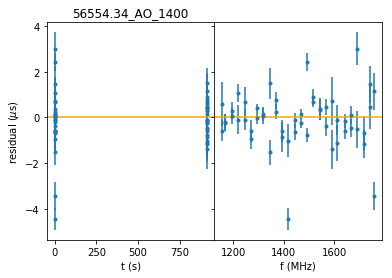

In [301]:
for o in bad_observations:
    plot_observation(o)

## Grouped residuals

In [302]:
groups = {}
for t in toa_infos:
    f = t["file"]
    if f not in groups:
        groups[f] = []
    groups[f].append(t)

In [303]:
def combine(values, uncerts):
    weights = 1/uncerts
    sw = np.sum(weights)
    v = np.sum(weights*values)/sw
    u = np.sqrt(np.sum((weights*uncerts)**2))/sw
    return v,u

In [304]:
tels = set()
avgs = []
for k in sorted(groups.keys()):
    ts = groups[k]
    r = np.array([1e6*t["flags"]["resid_s"] for t in ts])
    u = np.array([t["uncert"] for t in ts])
    m = np.array([t["mjd"] for t in ts])
    ipms = np.array([float(t["flags"]["ipm"]) for t in ts])
    ar, au = combine(r,u)
    am, _ = combine(m,u)
    ipm, _ = combine(ipms,u)
    tels.add(t["tel"])
    if au<0.5:
        avgs.append(dict(key=k,mjd=am,res=ar,uncert=au, 
                         ipm=ipm,tel=t["tel"]))

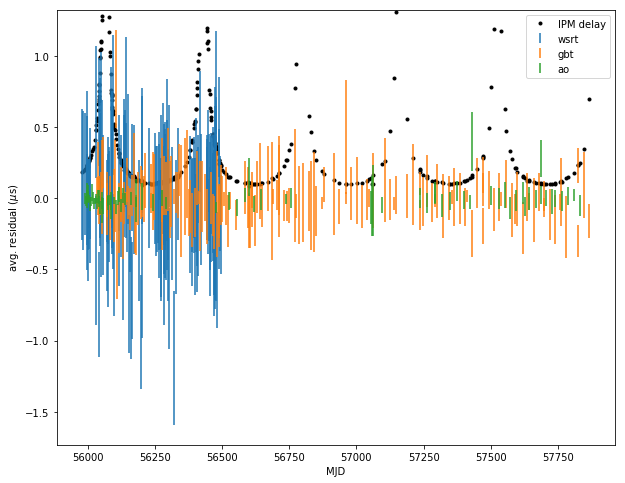

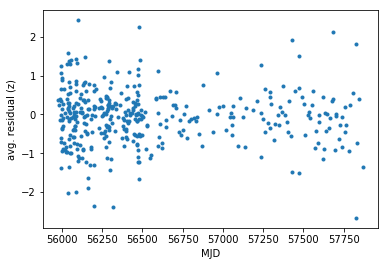

In [305]:
for t in sorted(tels)[::-1]:
    plt.errorbar([a["mjd"] for a in avgs if a["tel"]==t], 
               [a["res"] for a in avgs if a["tel"]==t],
               [a["uncert"] for a in avgs if a["tel"]==t],
                  label=t,
                linestyle="none")
yl,yh = plt.ylim()
plt.plot([a["mjd"] for a in avgs],
         [1e6*a["ipm"] for a in avgs],
        "k.", zorder=-5, label="IPM delay")
plt.ylim(yl,yh)
plt.legend()
plt.xlabel("MJD")
plt.ylabel("avg. residual ($\mu$s)")
plt.gcf().set_size_inches(10,8)
plt.savefig("per-obs.pdf")
plt.figure()
plt.plot([a["mjd"] for a in avgs], 
           [a["res"]/a["uncert"] for a in avgs],
        ".")
plt.xlabel("MJD")
plt.ylabel("avg. residual (z)")



In [306]:
for a in avgs:
    if abs(a["res"]/a["uncert"])<10:
        continue
    k = a["key"].split("/")[2]
    print(k, 
          threebody.fmt(a["res"], a["uncert"]), 
          a["res"]/a["uncert"],
          a["ipm"]*1e6)

In [307]:
toa_infos[0]

{'file': 'data/obs/55956.70_WSRT_1400/tuned2/scrunch_0000.ar',
 'flags': {'P': '0.00273285578456',
  'band': '1400',
  'bw': '20.0',
  'chan': '5',
  'd_DECJ': -114.34782230827222804,
  'd_DM': 0.0020885569570895539705,
  'd_PMDEC': 62125.29238883441576,
  'd_PMRA': 238105.87077290701563,
  'd_PX': 1.0865478729817506872e-06,
  'd_RAJ': -438.25770076520723251,
  'day_bary': 36.698945946256860001,
  'ipm': 1.378891185207429149e-07,
  'max_smearing': '0.04241883288',
  'mode': 'fold',
  'nbin': '512',
  'phase': '0.30476971276',
  'pn': '-4530974479',
  'processing_name': 'tuned2',
  'reduced_chi2': '1.10940790474',
  'resid_phase': 0.00082768779247999191284,
  'resid_s': 2.2617302178848855357e-06,
  'snr': '11.1171428287',
  'solarangle': '105.804707157',
  'subint': '0',
  'tel': 'WSRT',
  'toa_name': 'aligned',
  'tsubint': '579.996288',
  'uncert': '0.000803623322186',
  'uncert_phase': 0.00080370190104991543,
  'uncert_scaled': '0.000846443861987',
  'weighted_frequency': '1429.375'}

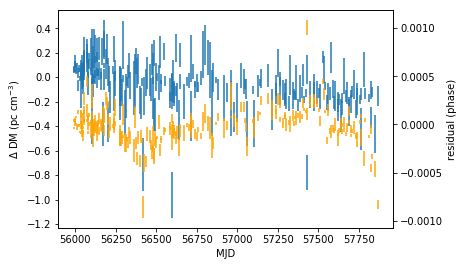

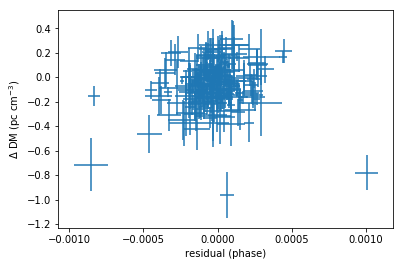

In [294]:
days = []
dms = []
dmus = []
dmuss = []
ipms = []
ress = []
resus = []
for k,ts in sorted(groups.items()):
    if len(ts)<3:
        continue
    rs = np.array([t['flags']['resid_phase'] for t in ts])
    us = np.array([t['flags']['uncert_phase'] for t in ts])
    d_DMs = np.array([t['flags']['d_DM'] for t in ts])
    A = np.array([np.ones(len(rs)), d_DMs]).T
    r = threebody.lstsq_with_errors(A, rs, us)
    
    res, resu = combine(rs, us)
    
    if r.uncerts[1]>0.3:
        continue
    
    
    days.append(np.mean([t["mjd"] for t in ts]))
    dms.append(r.x[1])
    dmus.append(r.uncerts[1])
    dmuss.append(r.uncerts[1]*np.sqrt(r.reduced_chi2))
    ipms.append(np.mean([t["flags"]["ipm"] for t in ts]))
    ress.append(res)
    resus.append(resu)
plt.errorbar(days, dms, dmus, linestyle="none", zorder=2)
plt.xlabel("MJD")
plt.ylabel(r"$\Delta$ DM (pc cm$^{-3}$)")
#plt.ylim(-1,1)
plt.twinx()
#plt.plot(days, np.array(ipms)*1e6, "k.", zorder=-10)
#plt.ylabel("Expected IPM delay ($\mu$s)")
plt.errorbar(days, ress, resus, 
             linestyle="none", color='orange', zorder=1)
plt.ylabel("residual (phase)")
plt.savefig("separate-dm-fits.pdf")
plt.figure()
plt.errorbar(ress, dms, dmus, resus, linestyle="none")
plt.ylabel(r"$\Delta$ DM (pc cm$^{-3}$)")
plt.xlabel(r"residual (phase)")
plt.savefig("dm-vs-residual.pdf")
